# PINN for DEs

This notebook implements Physics Informed Neural Network (PINN) to solve the logistic equation 
$$
\frac{df}{dx} - R\cdot f\cdot (1-f) = 0
$$

The idea is to represent the function $f$ by a neural network $f_\theta$ specified by the parameters $\theta$ and then optimize it to minimize the square of the DE above, i.e. to reach the function where the above equation is satisfied for the given domain. 

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [43]:
class PINN(nn.Module):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            num_outputs: int=1,
            activation: nn.Module = nn.Tanh()
    ):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.num_outputs = num_outputs
        self.activation = activation

        layers = [nn.Linear(num_inputs, num_neurons)]

        for _ in range(num_hidden_layers):
            layers.append(activation)
            layers.append(nn.Linear(num_neurons, num_neurons))
        
        layers.append(activation)
        layers.append(nn.Linear(num_neurons, num_outputs))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [44]:
R = 1.0
X_BOUNDARY=0.0
FUN_BOUNDARY=0.5
NUM_INPUTS = 1
NUM_OUTPUTS = 1
DOMAIN = (-5, 5)

In [45]:

def loss_function(
        model: nn.Module, 
        x: torch.Tensor,
        bx: torch.Tensor = torch.Tensor([X_BOUNDARY]), 
        bu: torch.Tensor = torch.Tensor([FUN_BOUNDARY]),
    ) -> torch.Tensor:
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

    pde = u_x - R*u*(1-u)
    bc = model(bx) - bu

    loss = torch.mean(pde**2) + torch.mean(bc**2)

    return loss

In [46]:
NUM_LAYERS = 5
NUM_NEURONS = 5
EPOCHS = 10000 #how many times the training step is performed
BATCH_SIZE = 30 # how many input values are considered for each epoch
LEARNING_RATE = 5e-3
TOLERANCE = 5e-7

In [47]:
from IPython.display import clear_output

In [48]:
model = PINN(num_inputs=NUM_INPUTS,  num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS, num_outputs=1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [49]:
def train_step(model,input):
    optimizer.zero_grad()
    loss = loss_function(model, input)
    loss.backward()
    optimizer.step()

    return loss


In [50]:
for epoch in range(EPOCHS):
    input_batch =  torch.rand(BATCH_SIZE, NUM_INPUTS) * (DOMAIN[1] - DOMAIN[0]) + DOMAIN[0] 
    input_batch.requires_grad_(True)
    loss = train_step(model, input_batch) 
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
    if loss <= TOLERANCE:
        break

clear_output()
print(f'Terminated at epoch {epoch}')

Terminated at epoch 5238


In [51]:
def analytical_sol_fn(
        x: torch.Tensor
)-> torch.Tensor:
    return 1.0 / (1.0 + (1.0/FUN_BOUNDARY - 1.0) * torch.exp(-R * x))

x_plot = torch.linspace(DOMAIN[0], DOMAIN[1], 1000).reshape(-1, 1)
y_pred = model(x_plot)
y_anlt = analytical_sol_fn(x_plot)

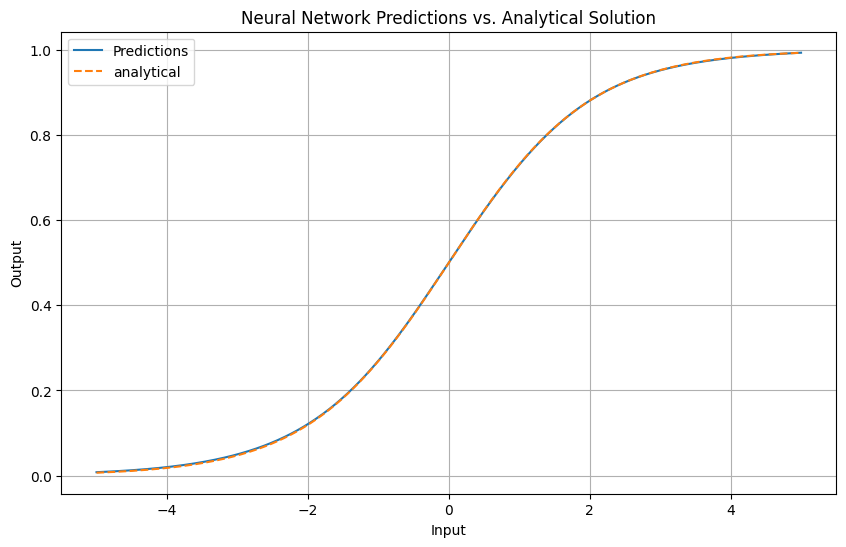

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(x_plot.detach(), y_pred.detach(), label='Predictions')
plt.plot(x_plot.detach(), y_anlt.detach(), label='analytical', linestyle='dashed')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Neural Network Predictions vs. Analytical Solution')
plt.legend()
plt.grid(True)
plt.show()